<a href="https://colab.research.google.com/github/doowilliams/Image-Classification-Using-HOG-Features-and-KNN/blob/main/sklearn_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
import zipfile


# Unzip our data
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset/cat_dag.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [3]:
# Function to load images
import os
import cv2
import numpy as np

def load_images(path, limit=None):

    images = []
    classes = []

    count = 0
    for filename in os.listdir(path):
        if limit is not None and count >= limit:
            break

        # Check if the file is an image
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            category = filename.split('.')[0]
            cls = 1 if category.lower() == 'dog' else 0
            img_path = os.path.join(path, filename)

            # Load image
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.resize(image, (128, 128))
                images.append(image)
                classes.append(cls)
                count += 1

    return np.array(images), np.array(classes)


In [4]:
# Load images and labels
images, classes = load_images("/content/cat_dog")
X_train, X_test, y_train, y_test = train_test_split(images, classes, train_size=0.8, test_size=0.2, random_state=42)

In [5]:
# Function to extract HOG features
def hogFeatures(image):
    features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    return features

hog_features = []
for image in X_train:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feature = hogFeatures(gray_image)
    hog_features.append(hog_feature)

In [6]:
# K-means clustering on HOG features to generate visual words vocabulary
kmeans = MiniBatchKMeans(n_clusters=100, random_state=42)
kmeans.fit(hog_features)
centroids = kmeans.cluster_centers_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [7]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
hog_features_pca = pca.fit_transform(hog_features)
cluster_labels = kmeans.predict(hog_features)

## K-means clustering with PCA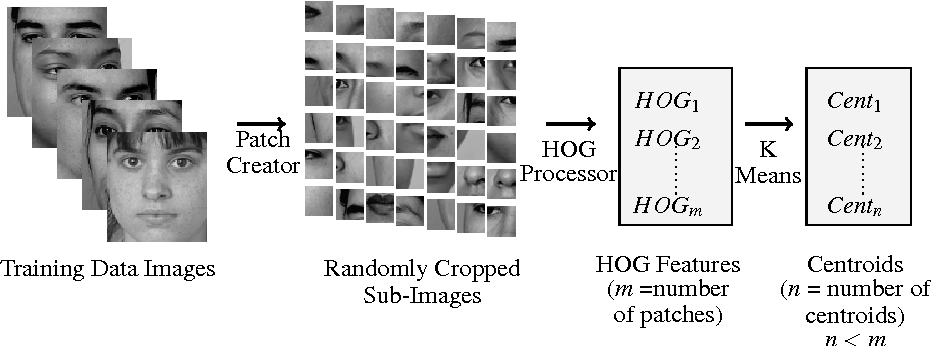

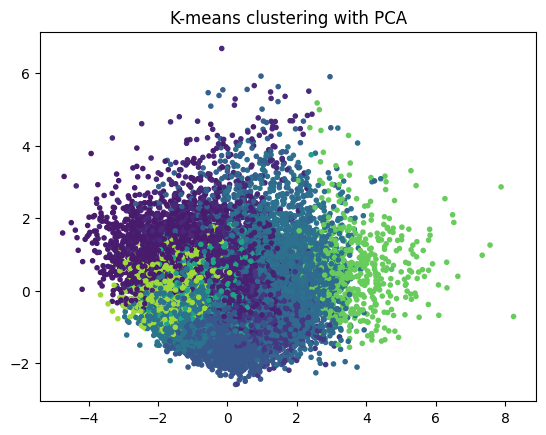

In [8]:
# Plotting the clusters
plt.scatter(hog_features_pca[:, 0], hog_features_pca[:, 1], c=cluster_labels, cmap='viridis', marker='.', label='Data Points')
plt.title('K-means clustering with PCA')
plt.show()

In [9]:
# BOW representation
x_train_bovw = np.array([np.histogram(kmeans.predict([hogFeatures(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))]), bins=range(101))[0] for image in X_train])
x_test_bovw = np.array([np.histogram(kmeans.predict([hogFeatures(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))]), bins=range(101))[0] for image in X_test])

# Train KNN classifier
KNN_classifier = KNeighborsClassifier(n_neighbors=40)
KNN_classifier.fit(x_train_bovw, y_train)

# Predictions
y_pred = KNN_classifier.predict(x_test_bovw)

from sklearn.metrics import classification_report
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy :", accuracy, "\n")
print(classification_report(y_test, y_pred))


Accuracy : 0.633 

              precision    recall  f1-score   support

           0       0.60      0.78      0.68      2471
           1       0.69      0.49      0.58      2529

    accuracy                           0.63      5000
   macro avg       0.65      0.63      0.63      5000
weighted avg       0.65      0.63      0.63      5000



## Combined Histogram of Visual Words

In [10]:
# Unzip our data
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset/cat_dog1.zip", "r")
zip_ref.extractall()
zip_ref.close()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


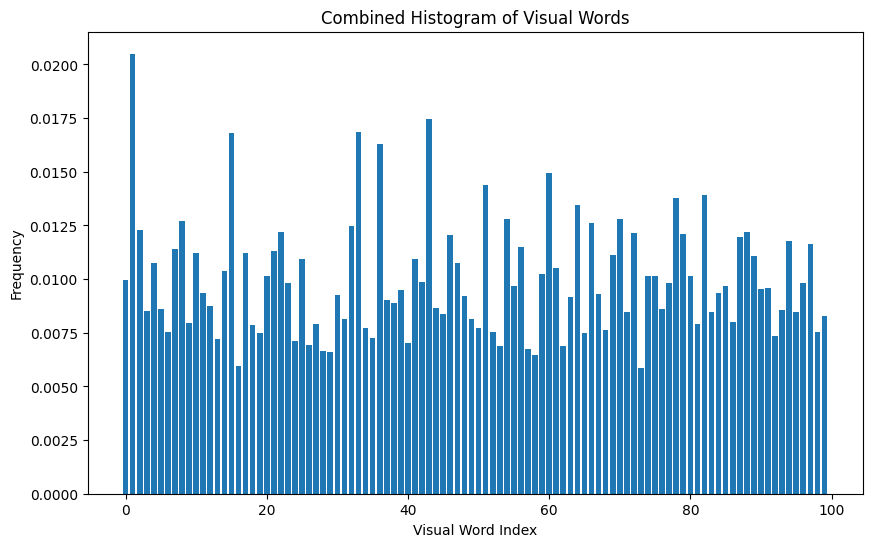

In [11]:
def bag_of_visual_words(images, n_clusters=100):
    sift = cv2.SIFT_create()
    descriptors = []
    for img in images:
        kp, des = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), None)
        if des is not None:
            descriptors.append(des)

    descriptors = np.vstack(descriptors)
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=100, max_iter=100)
    kmeans.fit(descriptors)

    histograms = []
    for des in descriptors:
        histogram, _ = np.histogram(kmeans.predict(des.reshape(1, -1)), bins=range(n_clusters+1))
        histograms.append(histogram)
    histograms = np.vstack(histograms)

    combined_histogram = np.sum(histograms, axis=0)  # Combine histograms along the rows

    # Normalize histogram
    normalized_histogram = combined_histogram / np.sum(combined_histogram)

    return normalized_histogram

# Load images and labels
image_dir = "/content/cat_dog1"
images = []
for filename in os.listdir(image_dir):
    img = cv2.imread(os.path.join(image_dir, filename))
    if img is not None:
        images.append(img)

# Plot the combined histogram
histograms = bag_of_visual_words(images)
plt.figure(figsize=(10, 6))
plt.bar(range(len(histograms)), histograms)
plt.xlabel('Visual Word Index')
plt.ylabel('Frequency')
plt.title('Combined Histogram of Visual Words')
plt.show()

# Report: Critique and Recommendation for Petfinder.com's Image Classifier

## Introductiuon:

Petfinder.com aims to develop an efficient binary image classifier capable of distinguishing between images of cats and dogs. The proposed solution involves a supervised learning approach using bags of visual words with k-means clustering of HOG features as features and k-nearest neighbors (KNN) as the classifier. This report critically evaluates this proposal in light of the stakeholders' wishes and makes a final recommendation.
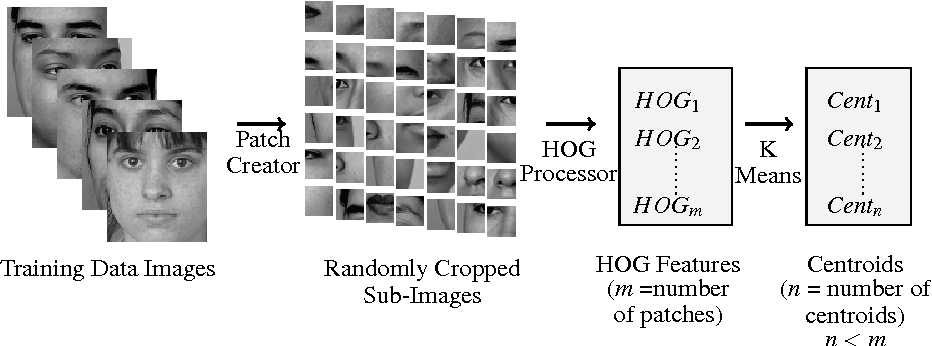

## Stakeholders' Wishes:

1. **Lead Data Scientist (S1)**:
* Requirement: The system should handle wide
variations in imaging conditions.
* Analysis: The use of bags of visual words with HOG features may not fully address this requirement. While HOG features are robust to some variations, they may not handle all types of variations efficiently.
2. **Lead Software Engineer (S2)**:
* Requirement: The system should be implementable in-house with no licensing issues.
* Analysis: The proposed solution satisfies this requirement as it uses open-source libraries like OpenCV and scikit-learn.
3. **Head of IT (S3)**:
* Requirement: The system should be computationally efficient.
* Analysis: The proposed solution may have high computational overhead during both training and prediction phases due to feature extraction, clustering, and KNN classification.
4. **Lead Data Engineer (S4)**:
* Requirement: The online content moderators should have a role after deployment.
* Analysis: The proposed solution does not directly address this requirement. Additional features might need to be incorporated to involve online content moderators.
5. **Charitable Donor (S5)**:
* Requirement: The system should be interpretable.
* Analysis: The proposed solution lacks interpretability. KNN as a classifier does not offer insight into decision-making, and bags of visual words may not be easily interpretable.

# Critical Analysis

* **Features**: The use of bags of visual words with HOG features may not adequately capture all variations in imaging conditions. While HOG features are robust to some extent, they may not handle variations like scale, rotation, and backgrounds effectively.
* **Classifier**: K-nearest neighbors (KNN) is simple and easy to implement but may not be the best choice for this task. It requires storing all training data, which can be memory-intensive, especially for large datasets like Petfinder's.
* **Computational Efficiency**: The proposed solution may have high computational overhead due to feature extraction and clustering. This could lead to scalability issues, especially with millions of images in the dataset.
* **Interpretability**: The proposed solution lacks interpretability, which conflicts with the requirement for stakeholders, especially non-technical ones, to understand the system's decisions.

# Recommendation
Based on the critical analysis and stakeholders' wishes, the following recommendations are made:

1. **Feature Selection**:
Instead of solely relying on HOG features, a more comprehensive feature extraction method like convolutional neural networks (CNNs) should be considered. CNNs can automatically learn relevant features from images, which may better handle variations in imaging conditions.
2. **Classifier Selection**:
Instead of KNN, a more sophisticated classifier like a support vector machine (SVM) or a deep neural network (DNN) should be explored. These classifiers can provide better performance and scalability.
3. **Computational Efficiency**:
To address computational overhead, a trade-off between computational complexity and accuracy should be considered. This might involve using a smaller vocabulary size for visual words or optimizing the clustering algorithm.
4. **Involvement of Online Content Moderators**:
Develop features or functionalities that involve online content moderators in the system, ensuring they have a role in its operation post-deployment.
5. **Interpretability**:
Incorporate techniques for model interpretability, such as attention mechanisms or feature visualization, to ensure that the system's decisions are understandable to all stakeholders.